# Project: Covid-19 detection based on breathing sounds

In this project, Covid-19 detection plays an important role in pandemic control. Different methods for the detection of covid-19 were presented, including, for example, the analysis of X-ray images of the lungs [1]. But is it possible to detect covid-19 from a patient's breath sounds alone? Analyze the available spectrograms of breath sounds [2]  and try to detect Covid-19. 

[1] http://dstore.alazhar.edu.ps/xmlui/handle/123456789/587

[2] https://www.kaggle.com/ruchi798/covid19-pulmonary-abnormalities

0. Prerequisites
1. Download dataset (spectrograms) related to COVID19 sounds.
2. Explore and Preprocess the data.
3. Building CNNs architectures.
4. Evaluate training and validation accuracy
5. Hyperparameter Tuning (applied in the model with best results).

***

**Hyperparameter Tuning guide**

- **High Bias**
  - ***Train longer:*** add more epochs.
  - ***Batch size:*** values starting from 8 to 32
  - ***NN Architectures:***
    - LeNet-5 original.
    - LeNet-5 modified.
    - Model I.
    - Model II.
    - VGG19.
    - Inception V3.
    - Xception.
  - ***Optimization Algorithms:***
    - SGD.
    - RMSprop.
    - Adam.
    - Adagrad.
- **High Variance**
  - ***Get more data:*** Data augmentation is not a valid practice for this project.
  - ***Regularization Techniques:***
    - Dropout.
    - L1.
    - L2.
    - Early stopping.
  - ***NN Architectures:***
    - LeNet-5 original.
    - LeNet-5 modified.
    - Model I.
    - Model II.
    - VGG19.
    - Inception V3.
    - Xception.
    
***


# General
**Authors**       

*   Viitalia Marina  - *TU Ilmenau* (Germany) & *KNRTU* (Russia).
    + *email:* viitalia.marina@tu-ilmenau.de
*   Ralina Safina    - *TU Ilmenau* (Germany) & *KNRTU* (Russia).
    + *email:* ralina.safina@tu-ilmenau.de
*   Ye Yun Khor      - *TU Ilmenau* (Germany).
    + *email:* ye-yun.khor@tu-ilmenau.de
*   Edwin G. Carreño - *TU Ilmenau* (Germany) & *KNRTU* (Russia).
    + *email:* edwin-carreno.lozano@tu-ilmenau.de

**Supervision**
*   M. Sc. Dominik Walther (*TU Ilmenau*)

**Repository:**
[Github](https://github.com/imciflam/covid-detection)

Year: 2021/2022

# 0 - Prerequisites



## PIP Installations

In [ ]:
## Library to create configure plots with paper guidelines
!pip install SciencePlots

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for SciencePlots: filename=SciencePlots-1.0.9-py3-none-any.whl size=6484 sha256=fc714dfd9758cca69bec4bce6ce4f7007e2af6eabc0aaaf3c4fadaeb918fb2a9
  Stored in directory: /root/.cache/pip/wheels/37/f8/e9/b2f53a40b336388dfc57b108150daff7d6ffbbfc618dba3924
Successfully built SciencePlots


In [ ]:
## Library for Hyperparameters Tuning over Keras 
!pip install keras-tuner --upgrade

     |████████████████████████████████| 98 kB 3.0 MB/s 


## Libraries Importation

In [ ]:
import matplotlib as mpl
import matplotlib.image as mpimg
import numpy as np
import os
import pandas as pd
import requests
import shutil
import tensorflow as tf
import zipfile

from google.colab import files
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tqdm import tqdm

# Printing library version
print('Matplotlib version:\t', mpl.__version__)
print('Numpy version:\t\t', pd.__version__)
print('Pandas version:\t\t', pd.__version__)
print('TensorFlow version:\t', tf.__version__)

Matplotlib version:	 3.2.2
Numpy version:		 1.1.5
Pandas version:		 1.1.5
TensorFlow version:	 2.7.0


## GPU-Support Verification
Uncomment when enable GPU support!

In [ ]:
### GPU Metadata

#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name), '', sep='\n')

#!nvidia-smi

# 1 - Data Exploration

## 1.1 - Dataset Downloader

In [ ]:
## Retrieving the TRAINING DATASET from repository

print("Downloading training Dataset ...")
!wget --no-check-certificate \
    https://github.com/imciflam/covid-detection/blob/main/train.zip?raw=true \
    -O /tmp/train.zip

--2022-01-25 01:40:46--  https://github.com/imciflam/covid-detection/blob/main/train.zip?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/imciflam/covid-detection/raw/main/train.zip [following]
--2022-01-25 01:40:46--  https://github.com/imciflam/covid-detection/raw/main/train.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/imciflam/covid-detection/main/train.zip [following]
--2022-01-25 01:40:46--  https://raw.githubusercontent.com/imciflam/covid-detection/main/train.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 20

In [ ]:
## Retrieving the VALIDATION DATASET from repository

print("Downloading validation Dataset ...")
!wget --no-check-certificate \
    https://github.com/imciflam/covid-detection/blob/main/val.zip?raw=true \
    -O /tmp/val.zip

--2022-01-25 01:40:48--  https://github.com/imciflam/covid-detection/blob/main/val.zip?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/imciflam/covid-detection/raw/main/val.zip [following]
--2022-01-25 01:40:48--  https://github.com/imciflam/covid-detection/raw/main/val.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/imciflam/covid-detection/main/val.zip [following]
--2022-01-25 01:40:48--  https://raw.githubusercontent.com/imciflam/covid-detection/main/val.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

## 1.2 - Extracting compressed data

In [ ]:
## Extracting TRAINING DATASET into the temporal directory /tmp/train
local_zip = '/tmp/train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')

## Extracting VALIDATION DATASET into the temporal directory /tmp/val
local_zip = '/tmp/val.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')

zip_ref.close()

In [ ]:
## Directories for COVID and NON-COVID samples (train and validation)

# Training subdirectories
cov_train = '/tmp/train/cov'
noncov_train = '/tmp/train/noncov'

# Validation subdirectories
cov_val = '/tmp/val/cov/'
noncov_val = '/tmp/val/noncov/'

## 1.3 - Data visualization

In [ ]:
def get_info_on_splitted_data(): 
  
  files_val_noncov = os.listdir(noncov_val)
  files_train_noncov = os.listdir(noncov_train)
  files_val_cov = os.listdir(cov_val)
  files_train_cov = os.listdir(cov_train)
  print("non-covid train samples: "+str(len(files_train_noncov)))
  print("non-covid val samples: "+str(len(files_val_noncov)))
  print("\ncovid train samples: "+str(len(files_train_cov)))
  print("covid val samples: "+str(len(files_val_cov)))
  print("\n% non-covid train size: {:0.3f}%".format(100 * len(files_train_noncov)/(len(files_train_noncov)+len(files_val_noncov))))
  print("% covid validation size: {:0.3f}%".format(100 * len(files_train_cov)/(len(files_train_cov)+len(files_val_cov))))

In [ ]:
get_info_on_splitted_data()

non-covid train samples: 2379
non-covid val samples: 311

covid train samples: 1500
covid val samples: 234

% non-covid train size: 88.439%
% covid validation size: 86.505%


In [ ]:
# Plotting some examples.

%matplotlib inline

def show_example_pics():
  nrows = 4
  ncols = 4
  pic_index = 0

  fig = mpl.pyplot.figure()
  fig.set_size_inches(ncols * 4, nrows * 4)

  pic_index += 8
  next_noncov_pic = [os.path.join(noncov_train, fname) 
                  for fname in os.listdir(noncov_train)[pic_index-8:pic_index]]
  next_cov_pic = [os.path.join(cov_train, fname) 
                  for fname in os.listdir(cov_train)[pic_index-8:pic_index]]

  for i, img_path in enumerate(next_noncov_pic + next_cov_pic):
    print(img_path)
    sp = mpl.pyplot.subplot(nrows, ncols, i + 1)
    sp.axis('Off') 
    img = mpimg.imread(img_path)
    image = Image.open(img_path)
    #print(image.format)
    #print(image.mode)
    #print(image.size)

    if (i<8):
      mpl.pyplot.title('NON-COVID')
    else:
      mpl.pyplot.title('COVID')
    mpl.pyplot.imshow(img)

  mpl.pyplot.show()

/tmp/train/noncov/non-covid_3 (631).jpg
/tmp/train/noncov/non-covid_1 (59).jpg
/tmp/train/noncov/non-covid_3 (331).jpg
/tmp/train/noncov/non-covid_4 (496).jpg
/tmp/train/noncov/non-covid_2 (58).jpg
/tmp/train/noncov/non-covid_3 (583).jpg
/tmp/train/noncov/non-covid_2 (116).jpg
/tmp/train/noncov/non-covid_4 (531).jpg
/tmp/train/cov/covid(2)_0131.jpg
/tmp/train/cov/covid(4)_0316.jpg
/tmp/train/cov/covid(1)_0224.jpg
/tmp/train/cov/covid(2)_0094.jpg
/tmp/train/cov/covid(4)_0422.jpg
/tmp/train/cov/covid(1)_0226.jpg
/tmp/train/cov/covid(1)_0241.jpg
/tmp/train/cov/covid(1)_0003.jpg


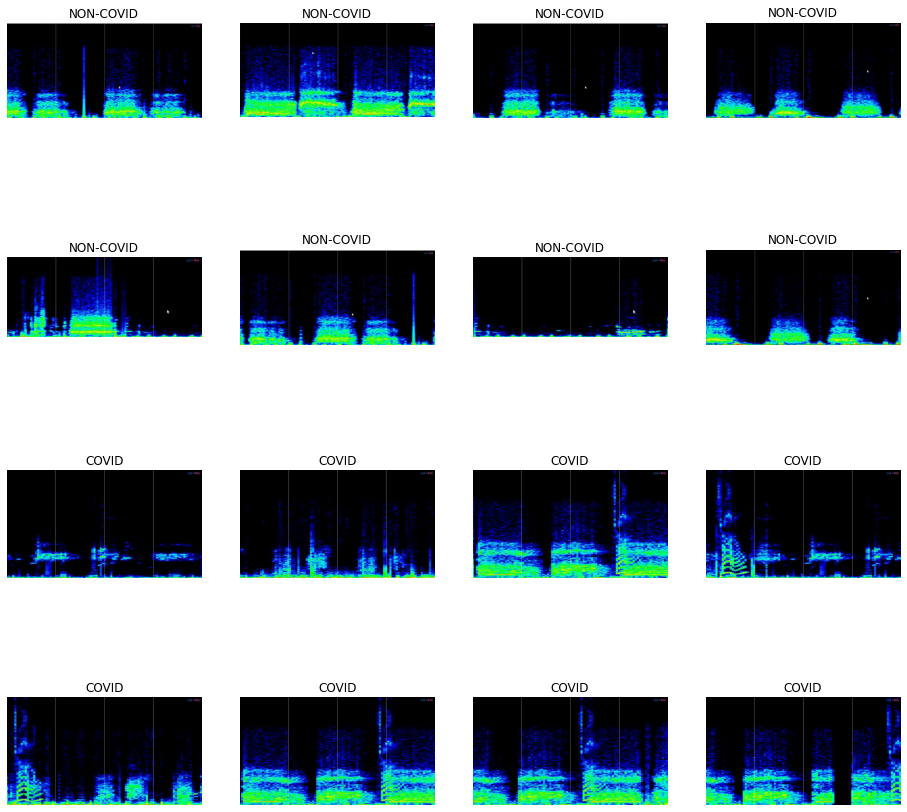

In [ ]:
show_example_pics()

# 2 - Data Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_HEIGHT = 256
IMG_WEIGHT = 256
BATCH_SIZE = 8

train_dir = '/tmp/train'
val_dir = '/tmp/val/'

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        classes = ['noncov', 'cov'],
        target_size=(IMG_HEIGHT, IMG_WEIGHT), 
        #batch_size=120,
        batch_size=BATCH_SIZE,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        classes = ['noncov', 'cov'],
        target_size=(IMG_HEIGHT, IMG_WEIGHT),
        #batch_size=19,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True)

print(train_generator.class_indices)

Found 3879 images belonging to 2 classes.
Found 545 images belonging to 2 classes.
{'noncov': 0, 'cov': 1}


# 3 - Utility Functions

In [ ]:
#@title Scientific Plots

mpl.pyplot.style.reload_library()
mpl.pyplot.style.use(['science','ieee', 'no-latex'])
mpl.pyplot.rcParams['font.family'] = "Liberation Serif"
#mpl.pyplot.rc('font', size=20, weight='bold') #controls default text size
#mpl.pyplot.rc('axes', titlesize=20) #fontsize of the title
#mpl.pyplot.rc('axes', labelsize=24) #fontsize of the x and y labels
#mpl.pyplot.rc('xtick', labelsize=20) #fontsize of the x tick labels
#mpl.pyplot.rc('ytick', labelsize=20) #fontsize of the y tick labels
#mpl.pyplot.rc('legend', fontsize=20) #fontsize of the legend

def plot_history(history, nameImage='plots_loss_accuracy.png'):
  fig, (ax1, ax2) = mpl.pyplot.subplots(2,1, sharex=True, dpi=150)
  ax1.set_xlim(1, 50)
  ax1.set_ylim(0, 1.01)
  ax1.plot(history.history['loss'], color='b', label='Training')
  ax1.plot(history.history['val_loss'], color='r', label='Validation')
  ax1.set_ylabel('Loss')
  ax1.legend()
  #ax1.set_yscale('log')
  if history.history.__contains__('lr'):
    ax1b = ax1.twinx()
    ax1b.plot(history.history['lr'], 'g-', linewidth=1)
    #ax1b.set_yscale('log')
    ax1b.set_ylabel('Learning Rate', color='g')

  ax2.set_xlim(1, 50)
  ax2.set_ylim(0.5, 1.01)
  ax2.plot(history.history['accuracy'], color='b', label='Training')
  ax2.plot(history.history['val_accuracy'], color='r', label='Validation')
  ax2.set_ylabel('Accuracy')
  #ax2.set_yscale('log')

  ax2.set_xlabel('Epochs')
  ax2.legend()

  mpl.pyplot.savefig(nameImage, dpi=300,transparent=True)
  files.download(nameImage)
  mpl.pyplot.show()

# 4 - Neural Networks Architectures (Exploration)

## 4.1 LeNet Original Architecture


### Architecture definition

In [ ]:
# Architecture definition

def build_model(input_shape=(IMG_HEIGHT, IMG_WEIGHT, 3)):
    input_img = layers.Input(shape=input_shape)

    first_conv = layers.Conv2D(filters=6, 
                               kernel_size=5,
                               input_shape = (32,32,1),
                               activation='sigmoid',  
                               padding='same')(input_img)           # <--- End layer

    first_pool = layers.AveragePooling2D(pool_size=2,
                                  strides=2)  (first_conv)          # <--- End layer 
    
    second_conv = layers.Conv2D(filters=16,
                                kernel_size=5,
                                activation='sigmoid') (first_pool)  # <--- End layer

    second_pool = layers.AveragePooling2D(pool_size=2,
                                      strides=2) (second_conv)      # <--- End layer 

    flatten = layers.Flatten()(second_pool)                         # <--- End layer 
    
    first_dense = layers.Dense(units=120,
                               activation='sigmoid')(flatten)     # <--- End layer 

    second_dense = layers.Dense(units=84,
                                activation='sigmoid')(first_dense) # <--- End layer 

    # 0 no covid 1 yes covid
    output = layers.Dense(units=1, activation='sigmoid')(second_dense) 

    model = Model(input_img, output, name="LeNet-5")
    model.summary()

    return model

### Pre-building Model

In [ ]:
# Pre-building model
model_lenet_original = build_model()

Model: "LeNet-5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 256, 256, 6)       456       
                                                                 
 average_pooling2d_6 (Averag  (None, 128, 128, 6)      0         
 ePooling2D)                                                     
                                                                 
 conv2d_9 (Conv2D)           (None, 124, 124, 16)      2416      
                                                                 
 average_pooling2d_7 (Averag  (None, 62, 62, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten_3 (Flatten)         (None, 61504)             0   

### Compiling Model

In [ ]:
model_lenet_original.compile(loss='binary_crossentropy',
              optimizer=RMSprop(),
              metrics='accuracy')

### Training

In [ ]:
history = model_lenet_original.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=50,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

### Evaluation

In [ ]:
#@title [evaluation] Loss & Accuracy
model_lenet_original.evaluate(validation_generator)

In [ ]:
#@title [plots] Loss & Accuracy 
namePlot = 'LeNet_original_256x256.svg'
plot_history(history_lenet_original, nameImage=namePlot)

## 4.2 LeNet Modified Architecture

### Architecture definition

In [ ]:
# Architecture definition

def build_model(input_shape=(IMG_HEIGHT, IMG_WEIGHT, 3)):
    input_img = layers.Input(shape=input_shape)

    first_conv = layers.Conv2D(filters=6, 
                               kernel_size=5,
                               input_shape = (32, 32, 1),
                               activation='relu',  
                               padding='same')(input_img)           # <--- End layer

    first_pool = layers.AvgPool2D(pool_size=2,
                                  strides=2)  (first_conv)          # <--- End layer 
    
    second_conv = layers.Conv2D(filters=16,
                                kernel_size=5,
                                activation='relu') (first_pool)  # <--- End layer

    second_pool = layers.MaxPooling2D(pool_size=2,
                                      strides=2) (second_conv)      # <--- End layer 

    flatten = layers.Flatten()(second_pool)                         # <--- End layer 
    
    first_dense = layers.Dense(units=120,
                               activation='relu')(flatten)     # <--- End layer 

    second_dense = layers.Dense(units=84,
                                activation='relu')(first_dense) # <--- End layer 

    # Output layer (1/0, COVID/NON-COVID)
    output = layers.Dense(units=1, activation='sigmoid')(second_dense) 

    # Model definition
    model = Model(input_img, output, name="LeNet-5")

    # Printing Model Summary (architecture)
    model.summary()

    return model

### Pre-building Model

In [ ]:
# Pre-building model
model_lenet_modified = build_model()

Model: "LeNet-5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 256, 6)       456       
                                                                 
 average_pooling2d (AverageP  (None, 128, 128, 6)      0         
 ooling2D)                                                       
                                                                 
 conv2d_5 (Conv2D)           (None, 124, 124, 16)      2416      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 61504)             0   

### Compiling Model

In [ ]:
model_lenet_modified.compile(loss='binary_crossentropy',
                              optimizer=Adam(),
                              metrics='accuracy')

### Training

In [ ]:
history_lenet_modified = model_lenet_modified.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=50,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/50
8/8 [==============================] - 2s 127ms/step - loss: 1.0183 - accuracy: 0.5469 - val_loss: 0.5992 - val_accuracy: 0.6094
Epoch 2/50
8/8 [==============================] - 1s 108ms/step - loss: 0.5266 - accuracy: 0.7812 - val_loss: 0.3229 - val_accuracy: 0.9531
Epoch 3/50
8/8 [==============================] - 1s 108ms/step - loss: 0.3295 - accuracy: 0.9375 - val_loss: 0.0845 - val_accuracy: 1.0000
Epoch 4/50
8/8 [==============================] - 1s 105ms/step - loss: 0.0509 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 5/50
8/8 [==============================] - 1s 107ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 2.8687e-04 - val_accuracy: 1.0000
Epoch 6/50
8/8 [==============================] - 1s 109ms/step - loss: 2.1323e-04 - accuracy: 1.0000 - val_loss: 7.0772e-05 - val_accuracy: 1.0000
Epoch 7/50
8/8 [==============================] - 1s 107ms/step - loss: 2.3150e-05 - accuracy: 1.0000 - val_loss: 7.7301e-06 - val_accuracy: 1.0000


### Evaluation

In [ ]:
#@title [evaluation] Loss & Accuracy
model_lenet_modified.evaluate(validation_generator)

69/69 [==============================] - 3s 37ms/step - loss: 5.0056e-07 - accuracy: 1.0000


[5.005583716410911e-07, 1.0]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

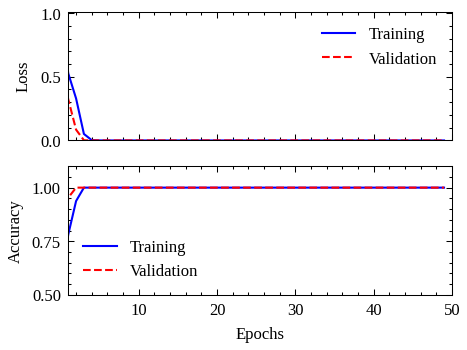

In [ ]:
#@title [plots] Loss & Accuracy 
namePlot = 'LeNet_256x256.svg'
plot_history(history_lenet_modified, nameImage=namePlot)

## 4.3 Model I (proposed by our group)

### Architecture definition

In [ ]:
def build_model(input_shape=(IMG_HEIGHT, IMG_WEIGHT, 3)):
    input_img = layers.Input(shape=input_shape)
    x = layers.Conv2D(filters = 16,
                      kernel_size = 3,
                      activation = 'relu')(input_img)
    x = layers.Dropout(.4)(x)
    x = layers.GlobalMaxPool2D()(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = Model(input_img, output, name="ModelI")
    model.summary()

    return model

### Pre-building Model

In [ ]:
# Pre-building model
model_modelI = build_model()

Model: "ModelI"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 dropout (Dropout)           (None, 254, 254, 16)      0         
                                                                 
 global_max_pooling2d (Globa  (None, 16)               0         
 lMaxPooling2D)                                                  
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 465
Trainable params: 465
Non-trainable params: 0
______________________________________________________________

### Compiling

In [ ]:
model_modelI.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=3e-4),
              metrics='accuracy')

### Training

In [ ]:
history_modelI = model_modelI.fit(
      train_generator,  
      epochs=50,
      steps_per_epoch=8,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/50
8/8 [==============================] - 1s 122ms/step - loss: 0.6415 - accuracy: 0.6562 - val_loss: 0.6805 - val_accuracy: 0.6406
Epoch 2/50
8/8 [==============================] - 1s 102ms/step - loss: 0.6827 - accuracy: 0.5156 - val_loss: 0.6827 - val_accuracy: 0.6250
Epoch 3/50
8/8 [==============================] - 1s 103ms/step - loss: 0.6857 - accuracy: 0.5156 - val_loss: 0.6827 - val_accuracy: 0.6250
Epoch 4/50
8/8 [==============================] - 1s 100ms/step - loss: 0.6627 - accuracy: 0.5469 - val_loss: 0.6874 - val_accuracy: 0.6406
Epoch 5/50
8/8 [==============================] - 1s 105ms/step - loss: 0.6150 - accuracy: 0.7188 - val_loss: 0.6792 - val_accuracy: 0.6562
Epoch 6/50
8/8 [==============================] - 1s 108ms/step - loss: 0.6144 - accuracy: 0.6719 - val_loss: 0.6846 - val_accuracy: 0.5781
Epoch 7/50
8/8 [==============================] - 1s 103ms/step - loss: 0.6265 - accuracy: 0.5781 - val_loss: 0.6763 - val_accuracy: 0.5938
Epoch 8/50
8/8 [====

### Evaluation

In [ ]:
#@title [evaluation] Loss & Accuracy
model_modelI.evaluate(validation_generator)

69/69 [==============================] - 3s 36ms/step - loss: 0.6289 - accuracy: 0.7927


[0.6289134621620178, 0.7926605343818665]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

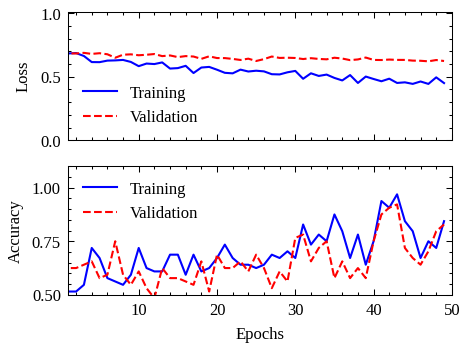

In [ ]:
#@title [plots] Loss & Accuracy 
namePlot = 'modelI_256x256.svg'
plot_history(history_modelI, nameImage=namePlot)

## 4.4 Model II (proposed by our group)

### Architecture definition

In [ ]:
# Architecture definition

def build_model(input_shape=(IMG_HEIGHT, IMG_WEIGHT, 3)):
    input_img = layers.Input(shape=input_shape)

    first_conv = layers.Conv2D(16, (3, 3), activation='relu')(input_img)    
    first_pool = layers.MaxPooling2D()(first_conv)
    
    second_conv = layers.Conv2D(32, (3, 3), activation='relu')(first_pool)
    second_pool = layers.MaxPooling2D()(second_conv)

    flatten_layer = layers.Flatten()(second_pool)
    
    first_dense = layers.Dense(64, activation='relu')(flatten_layer)

    # Output layer (1/0, COVID/NON-COVID)
    output = layers.Dense(1, activation='sigmoid')(first_dense) 
    
    # Model definition
    model = Model(inputs=input_img, outputs=output, name='ModelII')
    
    # Printing Model Summary (architecture)
    model.summary()

    return model

### Pre-building Model

In [ ]:
# Pre-building model
model_model2 = build_model()

Model: "ModelII"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 123008)            0   

### Compiling

In [ ]:
model_model2.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics='accuracy')

### Training

In [ ]:
history_model2 = model_model2.fit(
      train_generator,  
      epochs=50,
      steps_per_epoch=8,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8,
      batch_size=1)

Epoch 1/50
8/8 [==============================] - 1s 122ms/step - loss: 1.2391 - accuracy: 0.6875 - val_loss: 0.0516 - val_accuracy: 1.0000
Epoch 2/50
8/8 [==============================] - 1s 108ms/step - loss: 0.1027 - accuracy: 1.0000 - val_loss: 0.0114 - val_accuracy: 1.0000
Epoch 3/50
8/8 [==============================] - 1s 101ms/step - loss: 0.0171 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 4/50
8/8 [==============================] - 1s 108ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 5/50
8/8 [==============================] - 1s 106ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 8.2533e-04 - val_accuracy: 1.0000
Epoch 6/50
8/8 [==============================] - 1s 107ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 3.3545e-04 - val_accuracy: 1.0000
Epoch 7/50
8/8 [==============================] - 1s 136ms/step - loss: 9.7803e-04 - accuracy: 1.0000 - val_loss: 2.8637e-04 - val_accuracy: 1.0000
Epoc

### Evaluation

In [ ]:
#@title [evaluation] Loss & Accuracy
model_model2.evaluate(validation_generator)

69/69 [==============================] - 3s 37ms/step - loss: 1.4260e-06 - accuracy: 1.0000


[1.4259626368584577e-06, 1.0]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

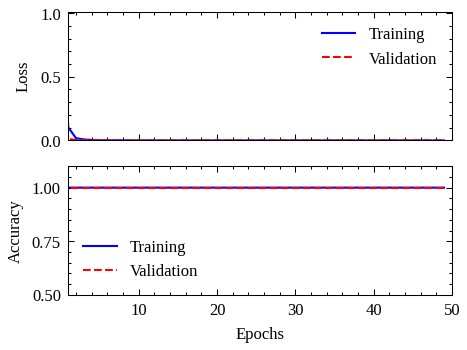

In [ ]:
#@title [plots] Loss & Accuracy 
namePlot = 'model2_256x256.svg'
plot_history(history_model2, nameImage=namePlot)

## 4.5 VGG19 Architecture

### Architecture definition

In [ ]:
def build_model(input_shape=(IMG_HEIGHT, IMG_WEIGHT, 3)):
    input_img = layers.Input(shape=input_shape)
    
    base_model = VGG19(weights='imagenet', include_top=False,input_tensor=input_img, input_shape=input_shape)
    
    x = base_model.output

    x = Flatten()(x)
    
    # First dense layer
    x = Dense(4096, activation='relu')(x)
    
    # Second dense layer
    #x = Dense(4096, activation='relu')(x)

    # Output layer (1/0, COVID/NON-COVID)
    predictions = Dense(1, activation='sigmoid')(x)

    # Model definition
    model = Model(inputs=base_model.input, outputs=predictions, name='VGG19')

    # Freezing all the Inception V3 layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Printing Model Summary (architecture)
    model.summary()

    return model

### Pre-building model

In [ ]:
# Pre-building model
model_vgg19 = build_model()

80150528/80134624 [==============================] - 1s 0us/step


NameError: ignored

### Compiling

In [ ]:
model_vgg19.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics='accuracy')

### Training

In [ ]:
history_vgg19 = model_vgg19.fit(
      train_generator,  
      epochs=50,
      steps_per_epoch=8,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

### Evaluation

In [ ]:
#@title [evaluation] Loss & Accuracy
model_vgg19.evaluate(validation_generator)

In [ ]:
#@title [plots] Loss & Accuracy 
namePlot = 'vgg19_256x256.svg'
plot_history(history_vgg19, nameImage=namePlot)

NameError: ignored

## 4.6 InceptionV3 Architecture

### Architecture definition

In [ ]:
# Architecture definition

def build_model(input_shape=(IMG_HEIGHT, IMG_WEIGHT, 3)):
    input_img = layers.Input(shape=input_shape)
    
    base_model = InceptionV3(weights='imagenet', include_top=False,input_tensor=input_img, input_shape=input_shape)
    
    x = base_model.output

    # Global Average Pooling Layer
    x = GlobalAveragePooling2D()(x)
    
    # First Dense Layer
    x = Dense(1024, activation='relu')(x)

    # Second Dense Layer
    x = Dense(1024, activation='relu')(x)
    
    # Output layer (1/0, COVID/NON-COVID)
    output = Dense(1, activation='sigmoid')(x)

    # Model Definition
    model = Model(inputs=base_model.input, outputs=output, name='InceptionV3')

    # Freezing all the Inception V3 layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Printing Model Summary (architecture)
    model.summary()

    return model

### Pre-building model

In [ ]:
# Pre-building model
model_inceptionv3 = build_model()

87924736/87910968 [==============================] - 1s 0us/step
Model: "InceptionV3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 127, 127, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 127, 127, 32  96         ['conv2d_9[0][0]']               
 rmalization)          

### Compiling

In [ ]:
model_inceptionv3.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics='accuracy')

### Training

In [ ]:
history_inceptionv3 = model_inceptionv3.fit(
      train_generator,  
      epochs=50,
      steps_per_epoch=8,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/50
8/8 [==============================] - 1s 138ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 4.4563e-04 - val_accuracy: 1.0000
Epoch 2/50
8/8 [==============================] - 1s 129ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 3/50
8/8 [==============================] - 1s 128ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 4/50
8/8 [==============================] - 1s 126ms/step - loss: 0.0207 - accuracy: 0.9844 - val_loss: 2.2010e-05 - val_accuracy: 1.0000
Epoch 5/50
8/8 [==============================] - 1s 123ms/step - loss: 0.0224 - accuracy: 0.9844 - val_loss: 3.3464e-04 - val_accuracy: 1.0000
Epoch 6/50
8/8 [==============================] - 1s 124ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.1161 - val_accuracy: 0.9844
Epoch 7/50
8/8 [==============================] - 1s 127ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 8/

### Evaluation

In [ ]:
#@title [evaluation] Loss & Accuracy
model_inceptionv3.evaluate(validation_generator)

69/69 [==============================] - 3s 48ms/step - loss: 1.0634e-06 - accuracy: 1.0000


[1.063354943653394e-06, 1.0]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

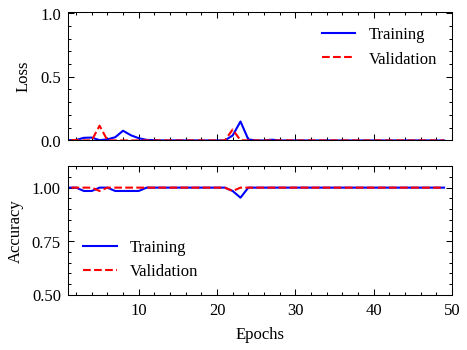

In [ ]:
#@title [plots] Loss & Accuracy 
namePlot = 'inceptionv3_256x256_base.svg'
plot_history(history_inceptionv3, nameImage=namePlot)

## 4.7 Xception Architecture

### Architecture definition

In [ ]:
# Architecture definition

def build_model(input_shape=(IMG_HEIGHT, IMG_WEIGHT, 3)):
    input_img = layers.Input(shape=input_shape)
    
    base_model = Xception(weights='imagenet', include_top=False, input_tensor=input_img, input_shape=input_shape)
    
    x = base_model.output

    # Global Average Pooling Layer
    x = GlobalAveragePooling2D()(x)
    
    # First dense layer
    firstDenseLayer = Dense(64, activation='relu')(x)

    # Output layer (1/0, COVID/NON-COVID)
    output = Dense(1, activation='sigmoid')(firstDenseLayer)

    # Model definition
    model = Model(inputs=base_model.input, outputs=output, name='Xception')

    # Freezing all the Inception V3 layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Printing Model Summary (architecture)
    model.summary()

    return model

### Pre-building Model

In [ ]:
# Pre-building model
model_xception = build_model()

Model: "Xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

### Compiling

In [ ]:
model_xception.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics='accuracy')

### Training

In [ ]:
history_xception = model_xception.fit(
      train_generator,  
      epochs=50,
      steps_per_epoch=8,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8
      )

Epoch 1/50
8/8 [==============================] - 4s 230ms/step - loss: 0.6247 - accuracy: 0.6094 - val_loss: 0.5105 - val_accuracy: 0.6875
Epoch 2/50
8/8 [==============================] - 1s 130ms/step - loss: 0.4798 - accuracy: 0.7500 - val_loss: 0.3936 - val_accuracy: 0.7969
Epoch 3/50
8/8 [==============================] - 1s 137ms/step - loss: 0.3066 - accuracy: 0.9375 - val_loss: 0.3872 - val_accuracy: 0.7344
Epoch 4/50
8/8 [==============================] - 1s 134ms/step - loss: 0.3178 - accuracy: 0.9219 - val_loss: 0.2946 - val_accuracy: 0.8750
Epoch 5/50
8/8 [==============================] - 1s 135ms/step - loss: 0.2919 - accuracy: 0.9219 - val_loss: 0.4221 - val_accuracy: 0.7500
Epoch 6/50
8/8 [==============================] - 1s 131ms/step - loss: 0.1967 - accuracy: 0.9375 - val_loss: 0.3200 - val_accuracy: 0.7969
Epoch 7/50
8/8 [==============================] - 1s 138ms/step - loss: 0.1098 - accuracy: 1.0000 - val_loss: 0.3157 - val_accuracy: 0.8125
Epoch 8/50
8/8 [====

### Evaluation

In [ ]:
#@title [evaluation] Loss & Accuracy
model_xception.evaluate(validation_generator)

69/69 [==============================] - 4s 53ms/step - loss: 0.0771 - accuracy: 0.9780


[0.0770888403058052, 0.9779816269874573]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

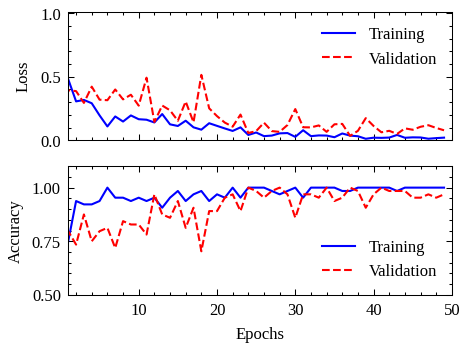

In [ ]:
#@title [plots] Loss & Accuracy 
namePlot = 'xception_256x256_base.svg'
plot_history(history_xception, nameImage=namePlot)

# 5 - Hyperparameters Tuning (search)

In [ ]:
#@title Architecture & Hyperparameters

import keras_tuner as kt
import time

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.regularizers import  l2

def model_architecture(units, activation, dropout_rate, learning_rate, penaltyReg, input_shape):
    
    input_img = layers.Input(shape=input_shape)
    
    base_model = Xception(weights='imagenet',
                          include_top=False,
                          input_tensor=input_img,
                          input_shape=input_shape)
    
    x = base_model.output

    # Global Average Pooling layer
    x = GlobalAveragePooling2D()(x)
    
    # First dense layer 
    firstDenseLayer = Dense(units=units,
                            activation=activation,
                            kernel_regularizer= l2(penaltyReg),
    )(x)

    # First dropout layer
    dropoutLayer1 = Dropout(dropout_rate)(firstDenseLayer)

    # Output layer (1/0, COVID/NON-COVID)
    output = Dense(1, activation='sigmoid')(dropoutLayer1)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=output, name='XceptionTuned')

    # Freezing all the Inception V3 layers
    for layer in base_model.layers[:-2]:
        layer.trainable = False
    
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics='accuracy')  

    # Printing Model Summary (architecture)
    model.summary()

    return model
  

def build_model(hp, input_shape=(IMG_HEIGHT, IMG_WEIGHT, 3)):
  
    # Hyperparameter ranges
    units=hp.Choice('units', [64, 128])
    activation = hp.Choice('activation', ['relu', 'tanh'])
    dropout_rate = hp.Choice('rate', [0.2, 0.4, 0.5, 0.8])
    penaltyReg = hp.Float('l2', min_value=0.0, max_value=1, step=0.2)
    
    model = model_architecture(
        units=units,
        activation=activation,
        dropout_rate=dropout_rate,
        learning_rate=1e-3,
        penaltyReg=penaltyReg,
        input_shape=(IMG_HEIGHT, IMG_WEIGHT, 3)
    )

    return model

### Configuration Tuner

In [ ]:
build_model(kt.HyperParameters())

Model: "XceptionTuned"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                     

In [ ]:
LOG_DIR='/tmp/logs/'

tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=100,
    executions_per_trial=1,
    overwrite=True,
    directory=LOG_DIR,
    project_name="DLWSProject",
)

In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.search(
    train_generator,
    epochs=2,
    batch_size=32,
    validation_data=validation_generator
)

In [ ]:
models = tuner.get_best_models(num_models=10)
best_model = models[0]

In [ ]:
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(IMG_HEIGHT, IMG_WEIGHT, 3))
best_model.summary()

In [ ]:
# Ranking of best hyperameters sets
tuner.results_summary()

### Retrain the model with best set (hyperparameter set) <--Optional

In [ ]:
# Ten best hyperparameter
best_hps = tuner.get_best_hyperparameters(10)

# Build the model with the best hyperparameter set.
model = build_model(best_hps[0])

In [ ]:
history = model.fit(train_generator,  
      epochs=50,
      steps_per_epoch=8,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

### Evaluation with the best hyperparameter set

In [ ]:
#@title [evaluation] Loss & Accuracy
model.evaluate(validation_generator)

In [ ]:
#@title [plots] Loss & Accuracy 
namePlot = 'modelTuned_256x256.png'
plot_history(history, nameImage=namePlot)

### Fine Tuning

In [ ]:
#@title Architecture for Manual Tuning

import keras_tuner as kt
import time

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.regularizers import  l2



def build_model(input_shape=(IMG_HEIGHT, IMG_WEIGHT, 3)):
    
    input_img = layers.Input(shape=input_shape)
    
    base_model = Xception(weights='imagenet',
                          include_top=False,
                          input_tensor=input_img,
                          input_shape=input_shape)
    
    x = base_model.output

    # Global Average Pooling layer
    x = GlobalAveragePooling2D()(x)
    
    # First dense layer 
    firstDenseLayer = Dense(units=64,
                            activation='tanh',
                            kernel_regularizer= l2(l2=0.0),
    )(x)

    # First dropout layer
    dropoutLayer1 = Dropout(0.5)(firstDenseLayer)
    
    # Output layer (1/0, COVID/NON-COVID)
    output = Dense(1, activation='sigmoid')(dropoutLayer1)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=output, name='XceptionTuned')

    # Freezing all the Inception V3 layers
    for layer in base_model.layers[:-2]:
        layer.trainable = False

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=1e-3),
                  metrics='accuracy')  

    print(base_model.layers)
    # Printing Model Summary (architecture)
    #model.summary()

    return model


In [ ]:
#@title Prebuilding model
model = build_model()

83697664/83683744 [==============================] - 1s 0us/step
[<keras.engine.input_layer.InputLayer object at 0x7f97eef7af90>, <keras.layers.convolutional.Conv2D object at 0x7f97ebfba0d0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f97ebfba150>, <keras.layers.core.activation.Activation object at 0x7f97ebe9a650>, <keras.layers.convolutional.Conv2D object at 0x7f97ebfa3310>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f97ebe5efd0>, <keras.layers.core.activation.Activation object at 0x7f97ebdfe390>, <keras.layers.convolutional.SeparableConv2D object at 0x7f97ebe06410>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f97ebe16610>, <keras.layers.core.activation.Activation object at 0x7f97ec0b5750>, <keras.layers.convolutional.SeparableConv2D object at 0x7f97ebe06690>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f97ebe1a5d0>, <keras.layers.convolutio

In [ ]:
#@ŧitle Retraining

# Learning schedule function
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

# Callbacks definition
my_callbacks = [
    #tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5),
    tf.keras.callbacks.LearningRateScheduler(scheduler)
]

# Training model
history = model.fit(train_generator,  
      epochs=50,
      steps_per_epoch=8,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8,
      callbacks=[my_callbacks])

Epoch 1/50
8/8 [==============================] - 32s 4s/step - loss: 0.7118 - accuracy: 0.6719 - val_loss: 0.5137 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 2/50
8/8 [==============================] - 28s 4s/step - loss: 0.5767 - accuracy: 0.7031 - val_loss: 1.0807 - val_accuracy: 0.5469 - lr: 0.0010
Epoch 3/50
8/8 [==============================] - 28s 4s/step - loss: 0.4856 - accuracy: 0.7969 - val_loss: 1.8168 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 4/50
8/8 [==============================] - 28s 4s/step - loss: 0.3502 - accuracy: 0.8438 - val_loss: 1.1240 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/50
8/8 [==============================] - 28s 4s/step - loss: 0.3085 - accuracy: 0.8750 - val_loss: 1.6899 - val_accuracy: 0.6094 - lr: 0.0010
Epoch 6/50
8/8 [==============================] - 28s 4s/step - loss: 0.3671 - accuracy: 0.8438 - val_loss: 1.8137 - val_accuracy: 0.6094 - lr: 0.0010
Epoch 7/50
8/8 [==============================] - 28s 4s/step - loss: 0.2245 - accuracy: 0.906

#### Evaluation

In [ ]:
#@title [evaluation] Loss & Accuracy
model.evaluate(validation_generator)

69/69 [==============================] - 127s 2s/step - loss: 0.1661 - accuracy: 0.9266


[0.16611023247241974, 0.9266055226325989]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

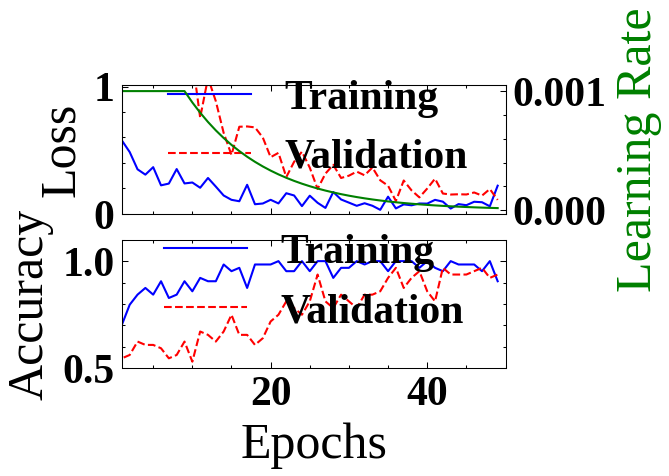

In [ ]:
#@title [plots] Loss & Accuracy 
namePlot = 'modelTuned_hp10_256x256.svg'
plot_history(history, nameImage=namePlot)

In [ ]:
#@title  Data processing in Y_true and Y_pred

validation_generator.reset()

X_val, Y_true = next(validation_generator)
for i in tqdm(range(int(len(validation_generator))-1)): 
  img, label = next(validation_generator)
  X_val = np.append(X_val, img, axis=0 )
  Y_true = np.append(Y_true, label, axis=0)
print(X_val.shape, Y_true.shape)


100%|██████████| 68/68 [00:07<00:00,  8.92it/s]

(545, 256, 256, 3) (545,)


In [ ]:
#@title Confusion Matrix and Classification Report

y_pred = model.predict(X_val)
Y_pred = [1 if x>=0.5 else 0 for x in y_pred]

print('Confusion Matrix')
print(confusion_matrix(Y_true, Y_pred))

print('Classification Report')
target_names = ['noncov', 'cov']

print(classification_report(Y_true, Y_pred, target_names=target_names))

Confusion Matrix
[[308   3]
 [ 37 197]]
Classification Report
              precision    recall  f1-score   support

      noncov       0.89      0.99      0.94       311
         cov       0.98      0.84      0.91       234

    accuracy                           0.93       545
   macro avg       0.94      0.92      0.92       545
weighted avg       0.93      0.93      0.93       545



In [ ]:
Y_pred.count(1)

200

## 6 Predictions Checker

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  img = image.load_img(path, target_size=(IMG_HEIGHT, IMG_WEIGHT))
  x = image.img_to_array(img)
  mpl.pyplot.imshow(x/255.)
  x = x/255.
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  #predictions = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]<0.5:
    print(fn + " --> noncovid")
  else:
    print(fn + " --> covid")